# Reuters News Text Classification
By: Cole Wagner, Haiyan Cai, and Joe Sellett

In [1]:
import pickle
import zipfile
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import metrics as mt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.datasets import reuters
from tensorflow.keras.layers import (
    Concatenate,
    Conv1D,
    Dense,
    Dropout,
    Embedding,
    Flatten,
    GlobalAveragePooling1D,
    Input,
    Layer,
    LayerNormalization,
    MaxPooling1D,
    MultiHeadAttention,
    Subtract,
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer


## Data Preparation

### Data Splitting Justification

We plan on splitting our data in a standard 80/20 train/test split. This approach is appropriate given that we have approximately 11,000 observations, which provides sufficient data to reserve 20% for testing without sacrificing model reliability. Additionally, even our lowest frequency class will maintain a few hundred observations after the split, which we believe is more than adequate for training a robust model. In our dataset, the classes represent different topics of documents, with each observation corresponding to a document labeled by its topic. This structure is common in text classification tasks, where the goal is to classify documents into predefined categories based on their content. This train/test split method mirrors common industry practices, where a significant portion of data is reserved for testing to ensure the model generalizes well to unseen data. By using this approach, we replicate a realistic scenario in which an algorithm is trained on a large dataset and evaluated on a held-out set, ensuring that performance metrics reflect real-world deployment conditions.

In [2]:
(x, y), (_, _) = reuters.load_data(
    seed=7324,
    test_split=0.0,
)

In [3]:
reuters_index = reuters.get_word_index(path="reuters_word_index.json")

In [4]:
# Map the words to their indices
word_index = {k: (v + 3) for k, v in reuters_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<OOV>"] = 2

# Convert x from integer data to text data
reverse_word_index = {value: key for key, value in word_index.items()}
x_text = [
    " ".join([reverse_word_index.get(i, "<OOV>") for i in seq])
    for seq in x
]

First, we want to visually inspect the length of the texts in the data to determine which length to standardize to.

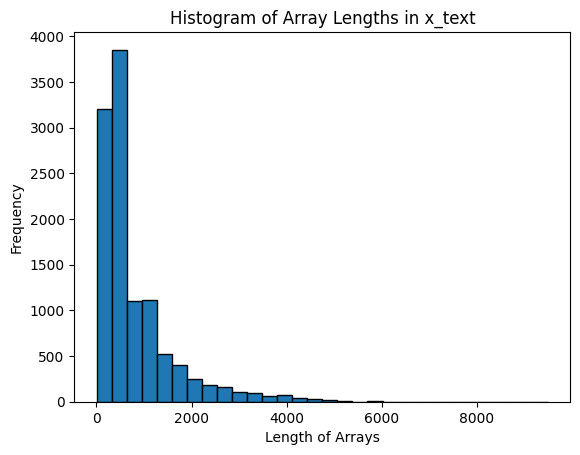

In [5]:
# Calculate the lengths of each array in x_train
x_lengths = [len(sequence) for sequence in x_text]

# Plot the histogram
plt.hist(x_lengths, bins=30, edgecolor="black")
plt.title("Histogram of Array Lengths in x_text")
plt.xlabel("Length of Arrays")
plt.ylabel("Frequency")
plt.show()

Based on a visual inspection of the distribution of text lengths, we can see that there is an extreme right skew in the data. The majority of the texts are less than 1000 characters, with a few outliers extending to over 5000 characters. Given this distribution, we will standardize the text length to 1000 characters. This length is long enough to capture the majority of the information in the texts while also being short enough to avoid excessive computational costs during model training and evaluation (along with lots of zero padding on shorter texts). Standardizing to this length will also help ensure that our model can handle a consistent input size, which is important for many machine learning algorithms.

Next we want to visually inspect the distribution of the labels in the data to determine if there is a class imbalance problem. If there is, we will need to take steps to address it.

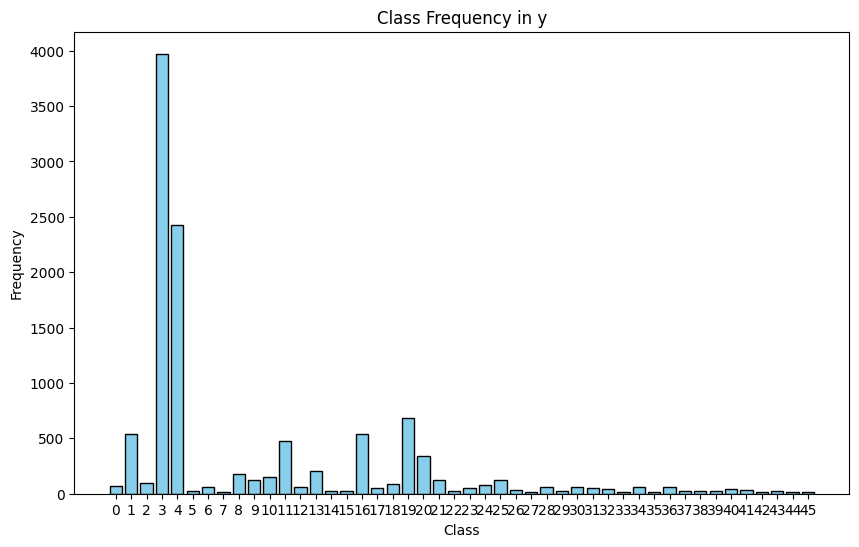

In [6]:
# Count the frequency of each class in y
class_counts = Counter(y)

# Extract classes and their frequencies
classes = list(class_counts.keys())
frequencies = list(class_counts.values())

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(classes, frequencies, color="skyblue", edgecolor="black")
plt.title("Class Frequency in y")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(classes)
plt.show()

Given that our dataset includes 46 classes, we opted to reduce the number to a more manageable subset for analysis. To achieve this, we employed a histogram to identify the most frequently occurring classes within the data. Upon reviewing the results, we observed that approximately eight classes were significantly more prevalent than the others. As a result, we chose to proceed with these eight classes, while consolidating the remaining classes into a single category labeled “other.”

In [7]:
# Find the frequency of labels in the training set
class_counts = Counter(y)

# Find the 8 most common labels
most_common_labels = class_counts.most_common(8)
most_common_labels

[(np.int64(3), 3972),
 (np.int64(4), 2423),
 (np.int64(19), 682),
 (np.int64(16), 543),
 (np.int64(1), 537),
 (np.int64(11), 473),
 (np.int64(20), 339),
 (np.int64(13), 209)]

In [8]:
# Keep only the most common labels and create "other" label
most_common_labels = dict(most_common_labels)
# Create a new list of labels
trunc_y = []
for label in y:
    if label in most_common_labels:
        trunc_y.append(label)
    else:
        trunc_y.append(0)


In [9]:
# Create a label mapping
label_mapping = {
    0: 0,
    1: 1,
    3: 2,
    4: 3,
    11: 4,
    13: 5,
    16: 6,
    19: 7,
    20: 8,
}

# Apply the mapping to the labels
trunc_y = [label_mapping[label] for label in trunc_y]

### Tokenization Strategy

We are using GloVe embeddings to convert words into dense vector representations, capturing semantic relationships for effective text classification. To prepare the data, we tokenize each document into words and enforce a fixed sequence length by padding shorter sequences and truncating longer ones. This ensures consistency in input size, making the data compatible with neural networks while managing computational efficiency.

### Evaluation Metric

Since there is no misclassification in our dataset that we consider significantly worse than another, we believe that accuracy remains a reasonable metric for evaluating model performance. A potential business case for this model would be a news article recommendation algorithm. In this business case, no one misclassification is worse than another. However, accuracy alone does not provide a complete view of the model’s effectiveness, especially when dealing with imbalanced classes. Therefore, we will also be examining additional metrics, such as the F1 score, to gain a more comprehensive understanding of the model's performance, particularly in terms of its ability to balance precision and recall. This broader evaluation will help ensure that the model performs well across various aspects of classification. 

## Modeling

### GloVe Embedding Preparation

GloVe embeddings can be downloaded at https://nlp.stanford.edu/projects/glove/. We will be using the embeddings with 6B tokens and 50 dimensions. The embeddings are stored in a text file, where each line contains a word followed by its corresponding vector representation.

This repo contains a zipped version of the GloVe embeddings, which are unzipped and loaded before training the model.

Credit: https://github.com/eclarson/MachineLearningNotebooks/blob/master/13a.%20Sequence%20Basics%20%5Bexperimental%5D.ipynb for the following cell.

In [10]:
NUM_TOP_WORDS = None  # use entire vocabulary!
MAX_ART_LEN = 1000  # maximum and minimum number of words

# tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(x_text)
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(x_text)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS == None else NUM_TOP_WORDS
top_words = min((len(word_index), NUM_TOP_WORDS))
print(
    "Found %s unique tokens. Distilled to %d top words."
    % (len(word_index), top_words),
)

x_padded = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y_ohe = keras.utils.to_categorical(trunc_y)
print("Shape of data tensor:", x.shape)
print("Shape of label tensor:", y_ohe.shape)


Found 30978 unique tokens. Distilled to 30978 top words.
Shape of data tensor: (11228,)
Shape of label tensor: (11228, 9)


In [11]:
X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(
    x_padded,
    y_ohe,
    test_size=0.2,
    stratify=y,
    random_state=7324,
)

In [12]:
# Extract the GloVe embeddings
with zipfile.ZipFile("glove.6B.50d.zip", "r") as z:
    z.extractall(".")

Credit: https://github.com/eclarson/MachineLearningNotebooks/blob/master/13a.%20Sequence%20Basics%20%5Bexperimental%5D.ipynb for the following cell.

In [13]:
EMBED_SIZE = 50
embeddings_index = {}
f = Path.open("glove.6B.50d.txt")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()

print("Found %s word vectors." % len(embeddings_index))

found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words + 1

print(
    "Embedding Shape:",
    embedding_matrix.shape,
    "\n",
    "Total words found:",
    found_words,
    "\n",
    "Percentage:",
    100 * found_words / embedding_matrix.shape[0],
)

Found 400000 word vectors.
Embedding Shape: (30979, 50) 
 Total words found: 24973 
 Percentage: 80.61267310113303


In [14]:
# Create the embedding layer
embedding_layer = Embedding(
    len(word_index) + 1,
    EMBED_SIZE,
    weights=[embedding_matrix],
    trainable=False,
)

### Model Selection

We choose CNN and Transformer as our two network architectures and built 4 models on those two architectures based on different layers or number of heads in our multi-headed attention layer(s). The models are as follows:
- Model1: CNN(2 convolutional layers)
- Model2: CNN(3 convolutional layers) 
- Model3: (Transformer; 1 transformer block with 2 heads)
- Model4: (Transformer; 1 transformer block with 4 heads)

Credit: https://github.com/eclarson/MachineLearningNotebooks/blob/master/13a.%20Sequence%20Basics%20%5Bexperimental%5D.ipynb for the following cell.

In [15]:
# The transformer architecture
class TransformerBlock(Layer):  # inherit from Keras Layer
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        # setup the model heads and feedforward network
        # these setup handles to the operations we will use
        # we have NOT yet setup any calls to add these operations to
        # the computation graph. Because we predict from the sequence
        # there is no need to use causal masking.
        self.att = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )

        # make a two layer network that can process the attention
        self.ffn = Sequential()
        self.ffn.add(Dense(ff_dim, activation="relu"))
        self.ffn.add(Dense(embed_dim))

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        # inputs:  keras tensor, tensors that need operations applied
        # training: boolean, are we in training mode?
        # apply the layers as needed (similar to PyTorch)

        # get the attention output from multi heads
        # Using same inpout here is self-attention
        # call inputs are (query, value, key)
        # if only two inputs given, value and key are assumed the same
        attn_output = self.att(inputs, inputs)

        # create residual output, with attention
        out1 = self.layernorm1(inputs + attn_output)

        # apply dropout if training
        out1 = self.dropout1(out1, training=training)

        # place through feed forward after layer norm
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)

        # apply dropout if training
        out2 = self.dropout2(out2, training=training)
        # return the residual from Dense layer
        return out2


class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        # create two embeddings
        # one for processing the tokens (words)
        self.token_emb = Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        # another embedding for processing the position
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)  # embed these positions
        x = self.token_emb(x)  # embed the tokens
        return x + positions  # add embeddngs to get final embedding


# first, let's replace the original embedding in the xformer
# with our custom GloVe embedding


class GloveTokenAndPositionEmbedding(Layer):
    def __init__(self):
        super().__init__()
        # create two embeddings
        # one for processing the tokens, pretrained (words)
        self.token_emb = Embedding(
            len(word_index) + 1,
            EMBED_SIZE,
            weights=[
                embedding_matrix
            ],  # here is the embedding getting saved
            input_length=MAX_ART_LEN,
            trainable=False,
        )

        # another embedding for processing the position
        self.pos_emb = Embedding(
            MAX_ART_LEN,
            EMBED_SIZE,
            input_length=MAX_ART_LEN,
            trainable=True,
        )

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)  # embed these positions
        x = self.token_emb(x)  # embed the tokens
        return x + positions  # add embeddngs to get final embedding

In [16]:
%matplotlib inline


def visual_performance(histories):
    combined = dict()
    for key in ["acc", "val_acc", "loss", "val_loss"]:
        combined[key] = np.hstack([x.history[key] for x in histories])

    # summarize history for accuracy
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(combined["acc"])
    plt.plot(combined["val_acc"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")

    # summarize history for loss
    plt.subplot(122)
    plt.plot(combined["loss"])
    plt.plot(combined["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()


In [17]:
def visual_performance_dict(histories_dict):
    combined = dict()
    for key in ["acc", "val_acc", "loss", "val_loss"]:
        combined[key] = np.hstack(
            [np.array(x) for x in histories_dict[key]]
        )

    # summarize history for accuracy
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(combined["acc"])
    plt.plot(combined["val_acc"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")

    # summarize history for loss
    plt.subplot(122)
    plt.plot(combined["loss"])
    plt.plot(combined["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()


## Model 1

CNN: 2 convolutional layers

In [18]:
NUM_CLASSES = 9
sequence_input = Input(shape=(MAX_ART_LEN,), dtype="int32")
# starting size: 1000
embedded_sequences = embedding_layer(
    sequence_input
)  # from previous embedding
x = Conv1D(128, 5, activation="relu", kernel_initializer="he_uniform")(
    embedded_sequences
)

# after conv, size becomes: 1000-4=996
x = MaxPooling1D(5)(x)  # after max pool, 996/5 = 199
x = Dropout(0.3)(x)

# x = Conv1D(128, 5, activation='relu',
#            kernel_initializer='he_uniform')(x)

# # new size is 195
# x = MaxPooling1D(5)(x) # after max pool, size is 195/5 = 39
# x = Dropout(0.2)(x)

x = Conv1D(128, 5, activation="relu", kernel_initializer="he_uniform")(x)

# after convolution, size becomes 15 elements long
# Take the mean of these elements across features, result is 128 elements
x_mean = GlobalAveragePooling1D()(
    x
)  # this is the size to globally flatten

# Take the variance of these elements across features, result is 128 elements
x_tmp = Subtract()([x, x_mean])
x_std = GlobalAveragePooling1D()(x_tmp**2)

x = Concatenate(name="concat_1")([x_mean, x_std])


x = Dense(128, activation="relu", kernel_initializer="he_uniform")(x)

x = Dropout(0.5)(x)

preds = Dense(
    NUM_CLASSES, activation="softmax", kernel_initializer="glorot_uniform"
)(x)

model_xvec_model1 = Model(sequence_input, preds)

# if representing as OHE, use categorical_crossentropy
# if representing the class as an integer, use sparse_categorical_crossentropy
model_xvec_model1.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["acc"]
)

print(model_xvec_model1.summary())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1000, 50)  │  1,548,950 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 996, 128)  │     32,128 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 199, 128)  │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 199, 128)  │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 195, 128)  │     82,048 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 195, 128)  │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ power (Power)       │ (None, 195, 128)  │          0 │ subtract[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ power[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_1            │ (None, 256)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     32,896 │ concat_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 9)         │      1,161 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,697,183 (6.47 MB)

 Trainable params: 148,233 (579.04 KB)

 Non-trainable params: 1,548,950 (5.91 MB)

None


In [19]:
# histories_model1 = []
# tmp_model1 = model_xvec_model1.fit(
#     X_train,
#     y_train_ohe,
#     validation_data=(X_test, y_test_ohe),
#     epochs=30,
#     batch_size=128,
# )
# histories_model1.append(tmp_model1)

# visual_performance(histories_model1)

In [20]:
# model_xvec_model1.save("models/model1.keras")
# with Path.open("histories/model1_history.pickle", "wb") as handle:
#     pickle.dump(histories_model1, handle, protocol=pickle.HIGHEST_PROTOCOL)

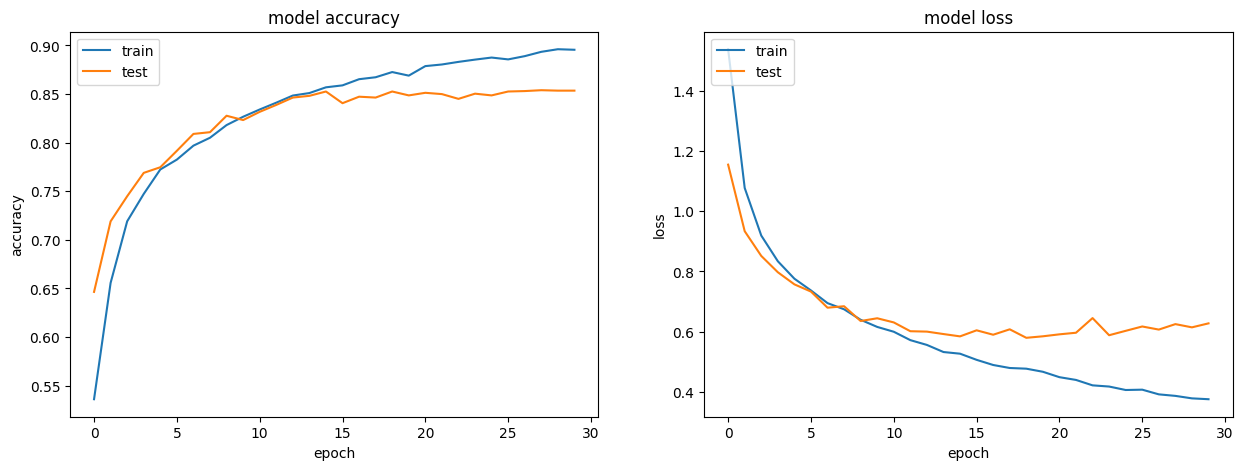

In [21]:
# Load and visualize the model history
with Path.open("histories/model1_history.pickle", "rb") as handle:
    histories_model1 = pickle.load(handle)

visual_performance(histories_model1)

## Model 2

CNN: 3 convolutional layers

In [22]:
EMBED_SIZE = 50  # same size as loaded from GLOVE
sequence_input = Input(shape=(MAX_ART_LEN,), dtype="int32")
# starting size: 1000
embedded_sequences = embedding_layer(
    sequence_input
)  # from previous embedding
x = Conv1D(128, 5, activation="relu", kernel_initializer="he_uniform")(
    embedded_sequences
)

# after conv, size becomes: 1000-4=996
x = MaxPooling1D(5)(x)  # after max pool, 996/5 = 199
x = Dropout(0.3)(x)

x = Conv1D(128, 5, activation="relu", kernel_initializer="he_uniform")(x)

# new size is 195
x = MaxPooling1D(5)(x)  # after max pool, size is 195/5 = 39
x = Dropout(0.2)(x)

x = Conv1D(128, 5, activation="relu", kernel_initializer="he_uniform")(x)

# after convolution, size becomes 15 elements long
# Take the mean of these elements across features, result is 128 elements
x_mean = GlobalAveragePooling1D()(
    x
)  # this is the size to globally flatten

# Take the variance of these elements across features, result is 128 elements
x_tmp = Subtract()([x, x_mean])
x_std = GlobalAveragePooling1D()(x_tmp**2)

x = Concatenate(name="concat_1")([x_mean, x_std])


x = Dense(128, activation="relu", kernel_initializer="he_uniform")(x)

x = Dropout(0.5)(x)

preds = Dense(
    NUM_CLASSES, activation="softmax", kernel_initializer="glorot_uniform"
)(x)

model_xvec_model2 = Model(sequence_input, preds)

# if representing as OHE, use categorical_crossentropy
# if representing the class as an integer, use sparse_categorical_crossentropy
model_xvec_model2.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["acc"]
)

print(model_xvec_model2.summary())


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1000, 50)  │  1,548,950 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 996, 128)  │     32,128 │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 199, 128)  │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 199, 128)  │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 195, 128)  │     82,048 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 39, 128)   │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 39, 128)   │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 35, 128)   │     82,048 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv1d_4[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_1          │ (None, 35, 128)   │          0 │ conv1d_4[0][0],   │
│ (Subtract)          │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ power_1 (Power)     │ (None, 35, 128)   │          0 │ subtract_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ power_1[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_1            │ (None, 256)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ concat_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 9)         │      1,161 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,779,231 (6.79 MB)

 Trainable params: 230,281 (899.54 KB)

 Non-trainable params: 1,548,950 (5.91 MB)

None


In [23]:
# histories_model2 = []
# tmp_model2 = model_xvec_model2.fit(
#     X_train,
#     y_train_ohe,
#     validation_data=(X_test, y_test_ohe),
#     epochs=30,
#     batch_size=128,
# )
# histories_model2.append(tmp_model2)

# visual_performance(histories_model2)

In [24]:
# model_xvec_model2.save("models/model2.keras")
# with Path.open("histories/model2_history.pickle", "wb") as handle:
#     pickle.dump(histories_model2, handle, protocol=pickle.HIGHEST_PROTOCOL)

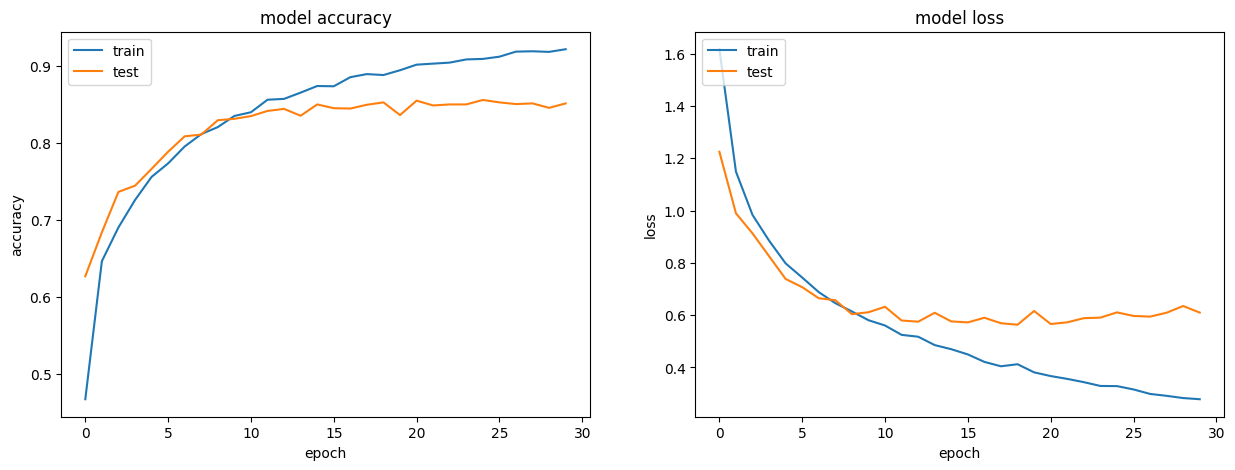

In [25]:
# Load and visualize the model history
with Path.open("histories/model2_history.pickle", "rb") as handle:
    histories_model2 = pickle.load(handle)

visual_performance(histories_model2)

## Model 3
Transformer: 1 transformer block with 2 heads

In [26]:
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
preds = Dense(
    NUM_CLASSES, activation="softmax", kernel_initializer="glorot_uniform"
)(x)

model_xformer20_model3 = Model(inputs=inputs, outputs=preds)
print(model_xformer20_model3.summary())

model_xformer20_model3.compile(
    loss="categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)

/Users/colewagner632/.pyenv/versions/3.12.5/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ glove_token_and_position_embed… │ (None, 1000, 50)       │     1,598,950 │
│ (GloveTokenAndPositionEmbeddin… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 1000, 50)       │        23,832 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 50)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,626,631 (6.21 MB)

 Trainable params: 77,681 (303.44 KB)

 Non-trainable params: 1,548,950 (5.91 MB)

None


In [27]:
# histories_model3 = []
# tmp_model3 = model_xformer20_model3.fit(
#     X_train,
#     y_train_ohe,
#     validation_data=(X_test, y_test_ohe),
#     epochs=15,
#     batch_size=32,
# )
# histories_model3.append(tmp_model3)
# visual_performance(histories_model3)

In [28]:
# model_xformer20_model3.save("models/model3.keras")
# histories_model3_dict = histories_model3[0].history
# with Path.open("histories/model3_history_dict.pickle", "wb") as handle:
#     pickle.dump(
#         histories_model3_dict, handle, protocol=pickle.HIGHEST_PROTOCOL
#     )

In [29]:
# Load and visualize the model history
with Path.open("histories/model3_history_dict.pickle", "rb") as handle:
    histories_model3_dict = pickle.load(handle)

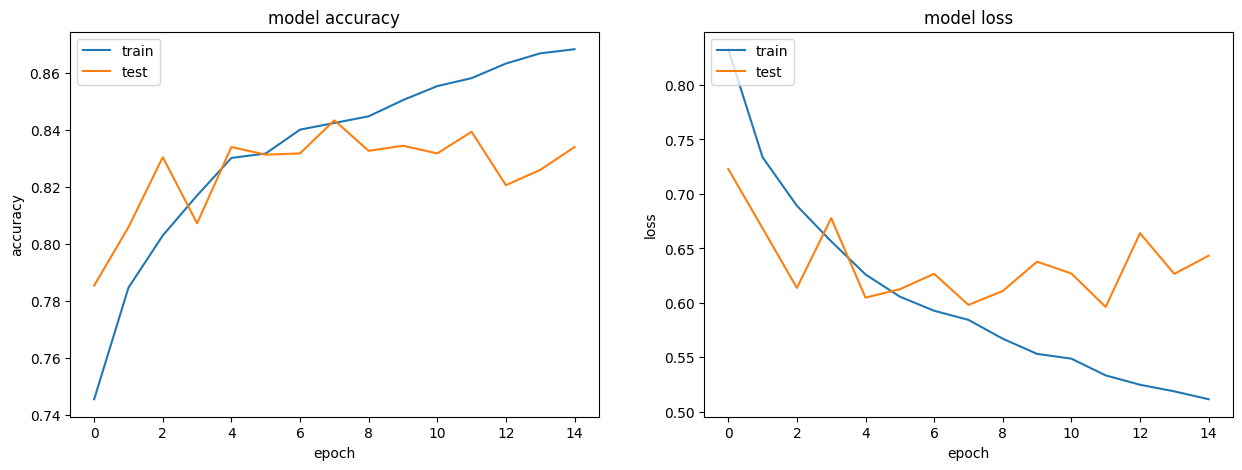

In [30]:
visual_performance_dict(histories_model3_dict)

## Model 4

Transformer: 1 transformer block with 4 heads

In [31]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
preds = Dense(
    NUM_CLASSES, activation="softmax", kernel_initializer="glorot_uniform"
)(x)

model_xformer20_model4 = Model(inputs=inputs, outputs=preds)
print(model_xformer20_model4.summary())

model_xformer20_model4.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["acc"]
)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ glove_token_and_position_embed… │ (None, 1000, 50)       │     1,598,950 │
│ (GloveTokenAndPositionEmbeddin… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 1000, 50)       │        44,132 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 50)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,646,931 (6.28 MB)

 Trainable params: 97,981 (382.74 KB)

 Non-trainable params: 1,548,950 (5.91 MB)

None


In [32]:
# histories_model4 = []
# tmp_model4 = model_xformer20_model4.fit(
#     X_train,
#     y_train_ohe,
#     validation_data=(X_test, y_test_ohe),
#     epochs=15,
#     batch_size=32,
# )
# histories_model4.append(tmp_model4)
# visual_performance(histories_model4)

In [33]:
# model_xformer20_model4.save("models/model4.keras")
# histories_model4_dict = histories_model4[0].history
# with Path.open("histories/model4_history_dict.pickle", "wb") as handle:
#     pickle.dump(
#         histories_model4_dict, handle, protocol=pickle.HIGHEST_PROTOCOL
#     )

In [34]:
# Load and visualize the model history
with Path.open("histories/model4_history_dict.pickle", "rb") as handle:
    histories_model4_dict = pickle.load(handle)

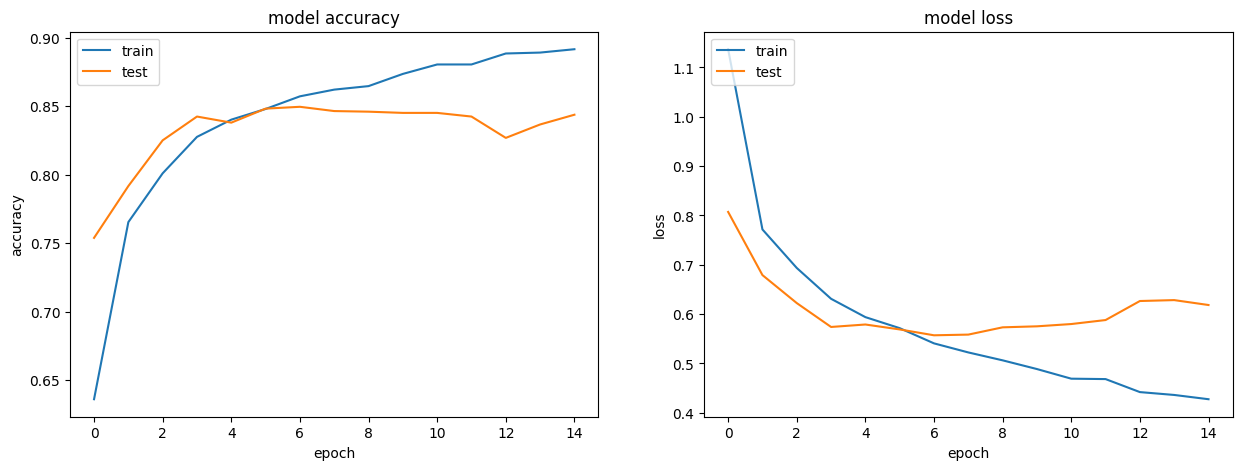

In [35]:
visual_performance_dict(histories_model4_dict)

## Add a second Multi-headed self attention layer

To try to improve the performance of our transformer model, we added a second multi-headed self attention layer. This layer is added after the first multi-headed self attention layer and before the feed forward layer.

In [36]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
# forgot layer norm here
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)
# forgot layer norm here
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
preds = Dense(
    NUM_CLASSES, activation="softmax", kernel_initializer="glorot_uniform"
)(x)

model_xformer20_extra5 = Model(inputs=inputs, outputs=preds)
print(model_xformer20_extra5.summary())

model_xformer20_extra5.compile(
    loss="categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ glove_token_and_position_embed… │ (None, 1000, 50)       │     1,598,950 │
│ (GloveTokenAndPositionEmbeddin… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 1000, 50)       │        44,132 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ (None, 1000, 50)       │        44,132 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_6      │ (None, 50)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,691,063 (6.45 MB)

 Trainable params: 142,113 (555.13 KB)

 Non-trainable params: 1,548,950 (5.91 MB)

None


In [37]:
# histories_extra5 = []
# tmp_extra5 = model_xformer20_extra5.fit(
#     X_train,
#     y_train_ohe,
#     validation_data=(X_test, y_test_ohe),
#     epochs=15,
#     batch_size=16,
# )
# histories_extra5.append(tmp_extra5)

# visual_performance(histories_extra5)

In [38]:
# model_xformer20_extra5.save("models/model5.keras")
# histories_extra5_dict = histories_extra5[0].history
# with Path.open("histories/model5_history_dict.pickle", "wb") as handle:
#     pickle.dump(
#         histories_extra5_dict, handle, protocol=pickle.HIGHEST_PROTOCOL
#     )

In [39]:
# Load and visualize the model history
with Path.open("histories/model5_history_dict.pickle", "rb") as handle:
    histories_model5_dict = pickle.load(handle)

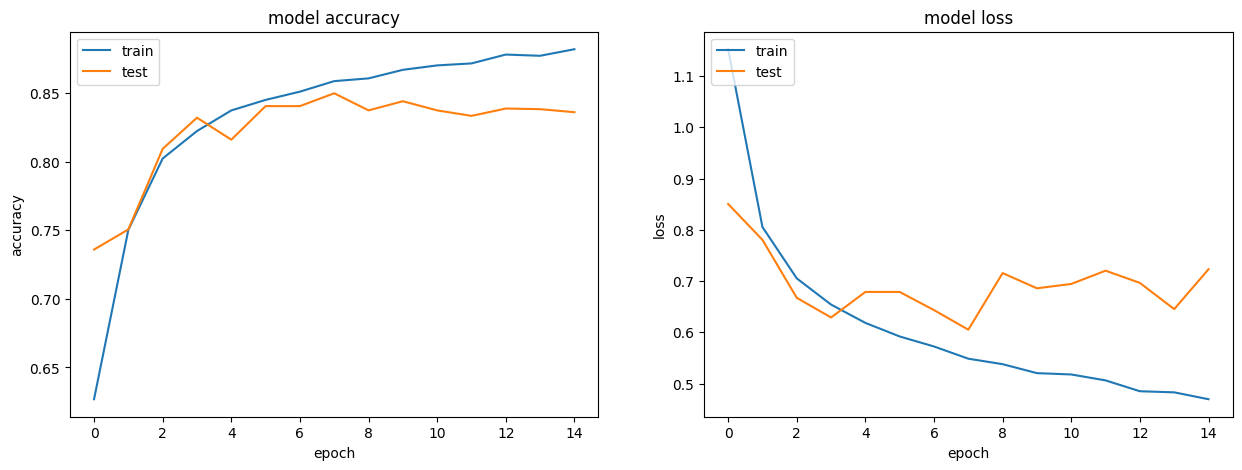

In [40]:
visual_performance_dict(histories_model5_dict)

From the visualization of 5 models above, we notice that :
- Overall, Transformers (Model 3 & 4) slightly outperform CNNs, suggesting self-attention mechanisms helps capture complex patterns and long-range dependencies. And Transformers has better generalization.
- In CNNs, compared to Model 1, Model 2(one more layers) achieves slightly higher training accuracy but slightly lower test accuracy. This suggests that the additional convolutional layer increased the model's capacity to fit the training data, but it also led to reduced generalization on unseen data.
- In Transformers, compared to Model3, Model 4(more multi-heads) achieves higher training accuracy. It means that additional multi-heads attention has stronger representation. However, its test accuray didn't improve. We guess it was likely due to the increased attention complexity, which may have captured more noise.
- After adding a second Multi-headed self attention layer to model4, we noticed that it acheived higher test accuracy. This indicates that deeper attention did improves performance. However, it didn’t surpass the performance of the model3 (2-head model), it means that more layers don’t always lead to better performance without careful tuning.


## Numberbatch vs. GloVe

Because all models performed similarly, we will use our simplest model architecture (CNN with 2 convolutional layers) to compare the performance of GloVe embeddings with Numberbatch embeddings.

In [41]:
# Map numberbatch embeddings

EMBED_SIZE = 300
embeddings_index = {}
f = Path.open("numberbatch.txt")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()

print("Found %s word vectors." % len(embeddings_index))

found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words + 1

print(
    "Embedding Shape:",
    embedding_matrix.shape,
    "\n",
    "Total words found:",
    found_words,
    "\n",
    "Percentage:",
    100 * found_words / embedding_matrix.shape[0],
)

Found 516783 word vectors.
Embedding Shape: (30979, 300) 
 Total words found: 20566 
 Percentage: 66.38690725975661


In [42]:
# Create the embedding layer
numbatch_embedding_layer = Embedding(
    len(word_index) + 1,
    EMBED_SIZE,
    weights=[embedding_matrix],
    trainable=False,
)

In [43]:
NUM_CLASSES = 9
sequence_input = Input(shape=(MAX_ART_LEN,), dtype="int32")
# starting size: 1000
embedded_sequences = numbatch_embedding_layer(
    sequence_input
)  # from previous embedding
x = Conv1D(128, 5, activation="relu", kernel_initializer="he_uniform")(
    embedded_sequences
)

# after conv, size becomes: 1000-4=996
x = MaxPooling1D(5)(x)  # after max pool, 996/5 = 199
x = Dropout(0.3)(x)

# x = Conv1D(128, 5, activation='relu',
#            kernel_initializer='he_uniform')(x)

# # new size is 195
# x = MaxPooling1D(5)(x) # after max pool, size is 195/5 = 39
# x = Dropout(0.2)(x)

x = Conv1D(128, 5, activation="relu", kernel_initializer="he_uniform")(x)

# after convolution, size becomes 15 elements long
# Take the mean of these elements across features, result is 128 elements
x_mean = GlobalAveragePooling1D()(
    x
)  # this is the size to globally flatten

# Take the variance of these elements across features, result is 128 elements
x_tmp = Subtract()([x, x_mean])
x_std = GlobalAveragePooling1D()(x_tmp**2)

x = Concatenate(name="concat_1")([x_mean, x_std])


x = Dense(128, activation="relu", kernel_initializer="he_uniform")(x)

x = Dropout(0.5)(x)

preds = Dense(
    NUM_CLASSES, activation="softmax", kernel_initializer="glorot_uniform"
)(x)

numbatch_model = Model(sequence_input, preds)

# if representing as OHE, use categorical_crossentropy
# if representing the class as an integer, use sparse_categorical_crossentropy
numbatch_model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["acc"]
)

print(numbatch_model.summary())


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 1000, 300) │  9,293,700 │ input_layer_9[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 996, 128)  │    192,128 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 199, 128)  │          0 │ conv1d_5[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 199, 128)  │          0 │ max_pooling1d_3[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 195, 128)  │     82,048 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv1d_6[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_2          │ (None, 195, 128)  │          0 │ conv1d_6[0][0],   │
│ (Subtract)          │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ power_2 (Power)     │ (None, 195, 128)  │          0 │ subtract_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ power_2[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_1            │ (None, 256)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 128)       │     32,896 │ concat_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 128)       │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 9)         │      1,161 │ dropout_24[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,601,933 (36.63 MB)

 Trainable params: 308,233 (1.18 MB)

 Non-trainable params: 9,293,700 (35.45 MB)

None


In [44]:
# histories_numbatch = []
# tmp_model6 = numbatch_model.fit(
#     X_train,
#     y_train_ohe,
#     validation_data=(X_test, y_test_ohe),
#     epochs=30,
#     batch_size=128,
# )

In [45]:
# histories_numbatch.append(tmp_model6)
# visual_performance(histories_numbatch)

In [46]:
# numbatch_model.save("models/model6.keras")
# histories_numbatch_dict = histories_numbatch[0].history
# with Path.open("histories/model6_history_dict.pickle", "wb") as handle:
#     pickle.dump(
#         histories_numbatch_dict, handle, protocol=pickle.HIGHEST_PROTOCOL
#     )

In [47]:
# Load and visualize the model history
with Path.open("histories/model6_history_dict.pickle", "rb") as handle:
    histories_numbatch_dict = pickle.load(handle)

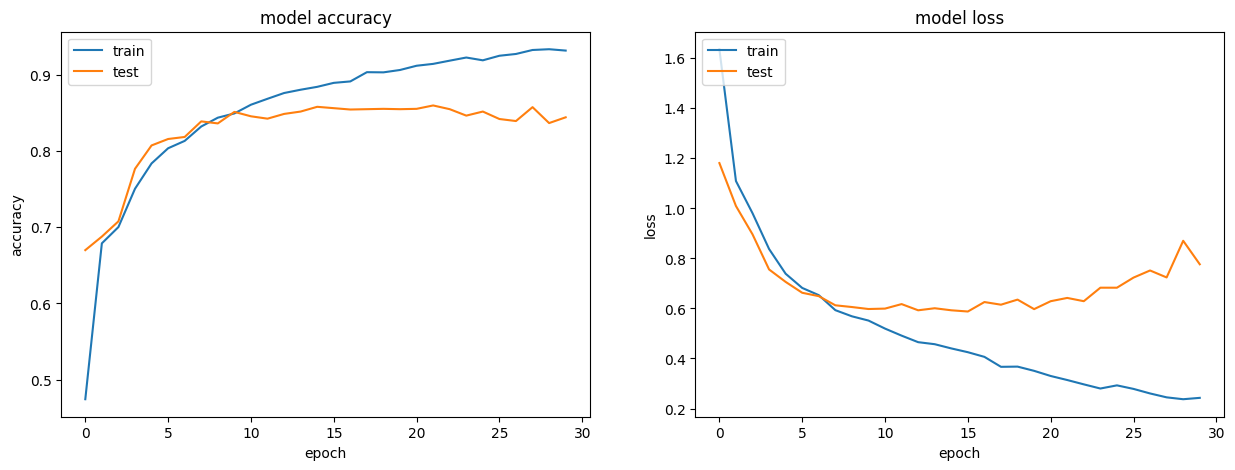

In [48]:
visual_performance_dict(histories_numbatch_dict)

From the visualization above, we noticed that:
- ConceptNet Numberbatch acheived higher training accuracy than GloVe, but slightly underperforms GloVe on test accuracy. This indicates that ConceptNet Numberbatch helps the model learn faster, but due to a major difference on the training accuracy and it's corresponding test accuracy, ConceptNet Numberbatch may fall in overfiting
- Overall, compared with our Model 2 (CNN with 3 convolutional layers using GloVe embedding), we still prefer Model 2. Because Model 2 using GloVe embedding achieved better performance with better generalization and stability.